In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
fname = "learn/vehicles/GTI_MiddleClose/image0113.png"
img = cv2.imread(fname)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.savefig(os.path.splitext(fname)[0] + "_RGB.png")
plt.show()


plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.savefig(os.path.splitext(fname)[0] + "_HSV.png")
plt.show()


plot3d(img_small_LUV, img_small_rgb, axis_labels=list("YUV"))
plt.savefig(os.path.splitext(fname)[0] + "_YUV.png")
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *

#import base64
#with open("test_image.jpg", "rb") as image_file:
#    encoded_string = base64.b64encode(image_file.read())
#    print (encoded_string)

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print (svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def cars2bbox(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 5  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append([[xbox_left, ytop_draw+ystart], [xbox_left+win_draw, ytop_draw+win_draw+ystart]]) # ((x1, y1), (x2, y2))
                
    return bbox_list

def get_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        print (heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]].shape)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], :] += np.array([70, 40, 10], dtype=heatmap.dtype)
        print ("heating range", str(box[0][1]) + ":" + str(box[1][1]) + " -> " + str(box[0][0]) + ":" + str(box[1][0])) 

    # Return updated heatmap
    return heatmap


ystart = 400
ystop = 656
scale = 1.5
    
bbox_list = cars2bbox(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heatmap = np.zeros_like(img).astype(np.uint8)
print (heatmap.shape)
heatmap = get_heat(heatmap, bbox_list)

plt.imshow(heatmap)

plt.show()

#out_img = 

#def find_cars_1(img1):
#    return find_cars(img1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#plt.imshow(out_img)


FileNotFoundError: [Errno 2] No such file or directory: 'svc_pickle.p'

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

t_from = 38
t_till = 42

#vidoe_output = 'project_video_out_' + str(t_from) + "-" + str(t_till) + '.mp4'
vidoe_output = 'project_video5_out.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip('project_video.mp4') #.subclip(t_from,t_till)
clip1_out = clip1.fl_image(find_cars_1)
%time clip1_out.write_videofile(vidoe_output, audio=False)

In [ ]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vidoe_output))

In [8]:

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

#print (svc, X_scaler)
print (orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

9 8 2 (32, 32) 32


C:\Users\Csabi\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version pre-0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Csabi\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version pre-0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


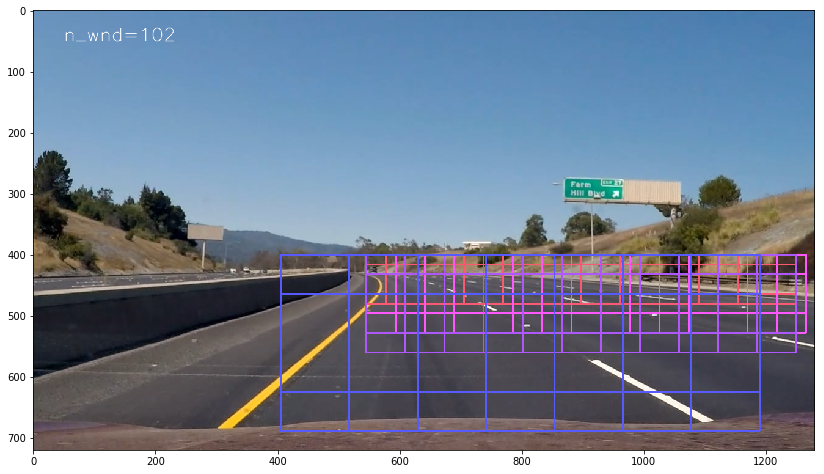

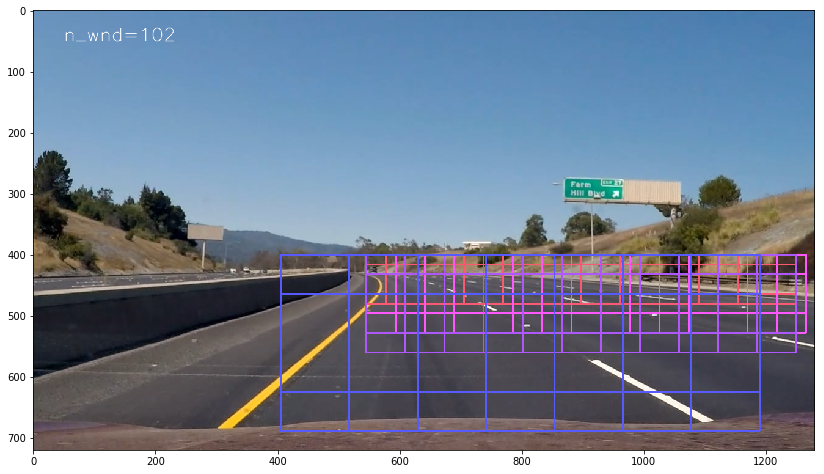

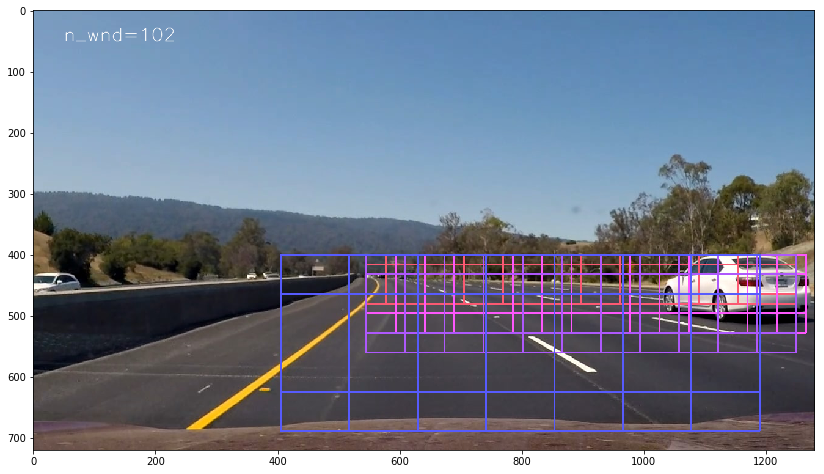

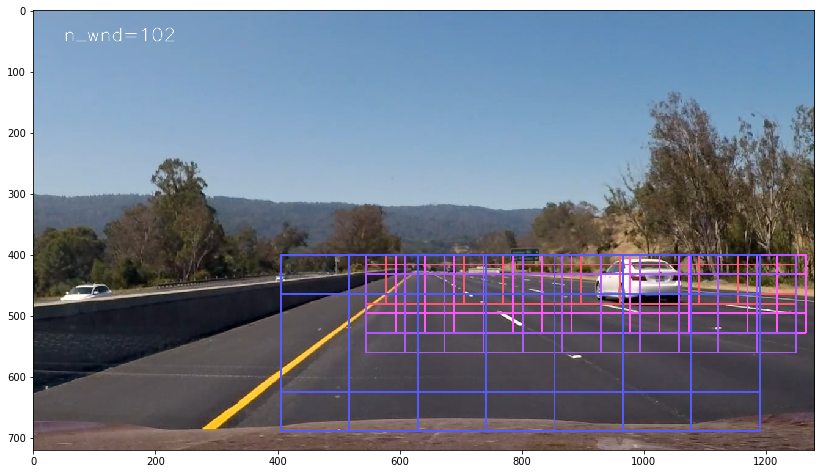

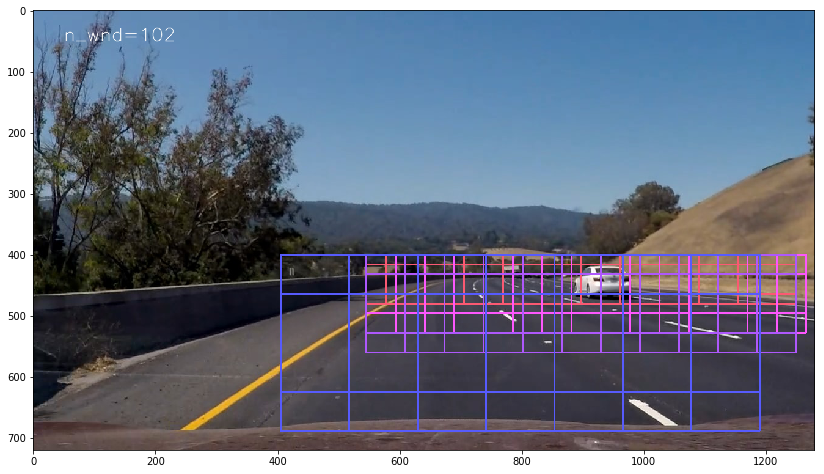

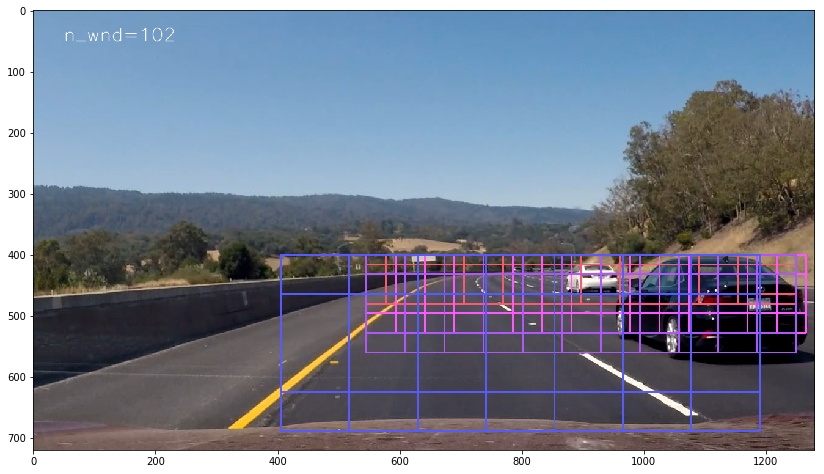

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


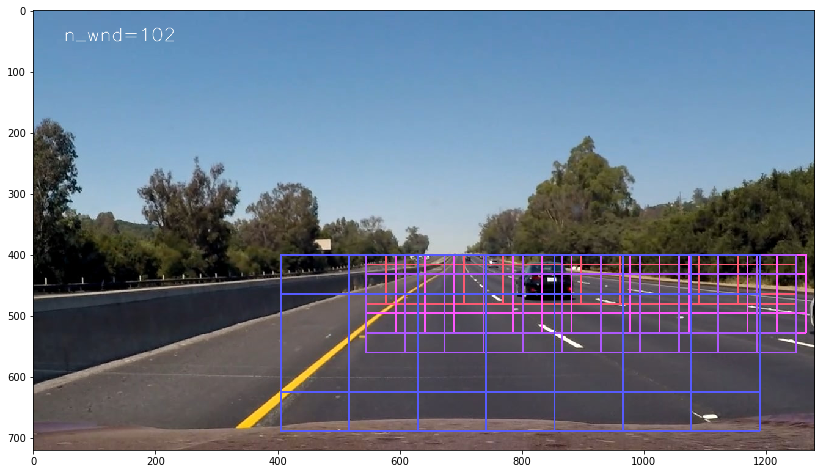

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        #color_rnd=(random.randrange(0, 256, 1), random.randrange(0, 256, 1), random.randrange(0, 256, 1))
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None),
    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start_stop = list(x_start_stop)
    y_start_stop = list(y_start_stop)
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#image = mpimg.imread('test_image.jpg')

image_fnames = \
    [
        'examples/cap_project_video_00_00_01_01.jpg',
        'examples/cap_project_video_00_00_10_02.jpg',
        'examples/cap_project_video_00_00_16_03.jpg',
        'examples/cap_project_video_00_00_25_04.jpg',
        'examples/cap_project_video_00_00_29_05.jpg',
        'examples/cap_project_video_00_00_37_06.jpg',
        'examples/cap_project_video_00_00_44_07.jpg',
        'examples/cap_project_video_00_00_48_08.jpg',
    ]

# windows should be easily converted into 64x64
regions = \
    [   # x_start_stop, y_start_stop, xy_window, xy_overlap, color
        #[ (None, None), (400, 485), ( 64,  64), (0.5, 0.7500), (251, 89, 114) ], # upper 1/4
        #[ (None, None), (400, 529), ( 96,  96), (0.5, 0.6667), (253, 87, 253) ], # upper 1/4-2/4
        #[ (None, None), (400, 560), (128, 128), (0.5, 0.7500), (174, 88, 252) ], # upper 2/4-3/4
        #[ (None, None), (400, 705), (224, 224), (0.5, 0.7143), ( 87, 91, 253) ], # upper 4/4-4/4
        [ (545, None), (400, 485), ( 64,  64), (0.5, 0.75), (251, 89, 114) ], # upper 1/4
        [ (545, None), (400, 529), ( 96,  96), (0.5, 0.66), (253, 87, 253) ], # upper 1/4-2/4
        [ (545, None), (400, 561), (128, 128), (0.5, 0.75), (174, 88, 252) ], # upper 2/4-3/4
        [ (405, None), (400, 705), (224, 224), (0.5, 0.71), ( 87, 91, 253) ], # upper 3/4-4/4         
    ]    
    
for fname in image_fnames:
    img = mpimg.imread(fname)
    
    n = 0
    for reg in regions:
        windows = slide_window(img, x_start_stop=reg[0], y_start_stop=reg[1],
            xy_window=reg[2], xy_overlap=reg[3])
        n += len(windows)
        img = draw_boxes(img, windows, color=reg[4], thick=2)

    #print (n)
    plt.figure(figsize=(14,9))
    cv2.putText(img, 'n_wnd=' + str(n), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    plt.imshow(img)
    mpimg.imsave(os.path.splitext(fname)[0] + "_boxes.jpg", img, format='jpg')
    
plt.show()

In [104]:
image = mpimg.imread("learn/vehicles/selection/13.png")
color_space = 'HLS'
# apply color conversion if other than 'RGB'
if color_space != 'RGB':
    if color_space == 'HSV':
        feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
else: feature_image_hist = np.copy(image)


def color_hist1(img, nbins=16, bins_range=(0, 16)):
    # Compute the histogram of the color channels separately
    #channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    #channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    #channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    hist_features = np.concatenate((np.histogram(img[:,:,0], bins=nbins, range=bins_range)))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

print (color_hist1(feature_image_hist))

[ 705.    1.    3.    0.    2.    7.    6.    7.    5.    7.   11.    6.
    8.    8.    2.   13.    0.    1.    2.    3.    4.    5.    6.    7.
    8.    9.   10.   11.   12.   13.   14.   15.   16.]


In [ ]:

#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
#svc = dist_pickle["svc"]
#X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

#print (svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)




img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def cars2bbox(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 5  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append([[xbox_left, ytop_draw+ystart], [xbox_left+win_draw, ytop_draw+win_draw+ystart]]) # ((x1, y1), (x2, y2))
                
    return bbox_list

def get_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        print (heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]].shape)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], :] += np.array([70, 40, 10], dtype=heatmap.dtype)
        print ("heating range", str(box[0][1]) + ":" + str(box[1][1]) + " -> " + str(box[0][0]) + ":" + str(box[1][0])) 

    # Return updated heatmap
    return heatmap


ystart = 400
ystop = 656
scale = 1.5
    
bbox_list = cars2bbox(img, ystart, ystop, scale, clf, feat_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heatmap = np.zeros_like(img).astype(np.uint8)
print (heatmap.shape)
heatmap = get_heat(heatmap, bbox_list)

plt.imshow(heatmap, figsize=(7,7))

plt.show()



In [146]:
from scipy.ndimage.measurements import label

def get_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print (heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]].shape)
        #heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], :] += np.array([70, 40, 10], dtype=heatmap.dtype)
        #print ("heating range", str(box[0][1]) + ":" + str(box[1][1]) + " -> " + str(box[0][0]) + ":" + str(box[1][0])) 
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def get_labels(heatmap):
    labels = label(heatmap)
    print(labels[1], 'cars found')
    return lables

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


img = cv2.imread('examples/cap_project_video_00_00_01_01.jpg')

bbox_list = [ [[400, 400], [600, 600]], [[450, 450], [650, 650]], [[300, 300], [500, 500]], [[350, 350], [550, 550]] ]
heatmap = np.zeros_like(img[:,:,0]).astype(np.uint8)
print (heatmap.shape)
heatmap = get_heat(heatmap, bbox_list)

plt.figure()
plt.imshow(heatmap, cmap='gist_heat')

heatmap = apply_threshold(heatmap, threshold=2)
plt.figure()
plt.imshow(heatmap, cmap='gist_heat')

labels = get_labels(heatmap)
plt.figure()
plt.imshow(labels[0], cmap='gray')


plt.show()

(720, 1280)
1 cars found


NameError: name 'lables' is not defined